# Vibration Reduction of Flexible Beam with Bayesian Input shaper

## Zsolt Pásztori
## CERN/ SMM-MRO-Robotics

In [1]:
#Imports
from IPython.core.display import Image, display
from IPython.core.display import HTML

import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
plt.rcParams["figure.figsize"] = (20,10)

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF

import json
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
%matplotlib inline
#

## Introduction

I work in the CERN Robotic Team as a PhD student. One of the experiments has asked us to design a mobile robot for inspection of their facilities. 
The robot has to fit 2 main criteria:

* has to be able to pass under 20 cm obstacles
* must be able to perform visual inspection between 20 cm and 1.5 meters

To ensure these requirements are met, we decided to fit a pan-tilt camera on top of a flexible beam.    
The beam can be raised with a motor up to 2 meters high. It can also be lowered to the base of the robot.

![](cernbot_small.jpg)

The beam has a low weight so it can be moved quickly.
This however means that the beam is not stiff. It vibrates when the robot is moving. This results in poor video feed.
The vibration is induced by the linear acceleration of the robot and the unevenness of the surface.

Bellow you can see the video taken on top of the flexible beam.
It can be observed that the oscillation of the camerea, is mainly caused by the initial acceleration of the robot.
It dies down very quickly when it is moving with constant velocity tough.

In [2]:
HTML('<iframe width="300" height="500" src="https://www.youtube.com/embed/1AbahaqgWqU" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/robotronics/.local/lib/python3.5/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Brain Storming of Solutions

To get rid of the vibration of the camera, I can see 4 possible solutions.

### 1. Drive slowly
* <span style="color:red">limits the movement of the robot</span>
* <span style="color:green">no need to implement anything</span> 

### 2. Balance with accelerating/breaking the robot
* <span style="color:red">needs a sensor to give feedback of the beam position</span>
* <span style="color:red">needs perfect control of the robotic base</span>
* <span style="color:red">the beam movement must be modeled</span>
* <span style="color:green">no need for additional actuator</span>
* <span style="color:green">easy to implement the hardware, medium hard software</span>

### 3. Corrigate the video camera with a gimbal
* <span style="color:red">needs a sensor to give feedback of the beam position</span>
* <span style="color:red">needs 2 additional gimbal motors</span>
* <span style="color:red">an additonal software needed for the control of the gimbal</span>
* <span style="color:green">no need to change the code of the robot base</span>
* <span style="color:green">medium hard hardware, medium hard software</span>

### 4. Use reaction wheels to stabilize the top of the beam
* <span style="color:red">needs a sensor to give feedback of the beam position</span>
* <span style="color:red">needs 2 custom machined reaction wheels (very expensive)</span>
* <span style="color:red">needs 2 additional motors to rotate the wheels</span>
* <span style="color:red">complicated control to stabilize the beam</span>
* <span style="color:red">the high weight makes the beam movement slower</span>
* <span style="color:green">no need to change the code of the robot base</span>
* <span style="color:green">very hard hardware, very hard software</span>

I decided to go with solution number 2. The main reason is that it doesn't require additional hardware components, just a simple sensor. 

In my experience in a system the bigger the complexity of the hardware the higher the cahnce to fail during extended operation.

## Experiment Set UP


### The Hardware

The robot base is equipped with 4 Maxon EC motors. The motors are controlled with the EPOS2 servo controller.
The brain of the robot is a commercially available NUC computer with Ubuntu on it. 
To get the position feedback from the beam I have placed a VMU931 IMU sensor on the top. 
The sensor has built in accelerometer, gyroscope and magnetometer. 
I only used the gyroscope measurements, because they have lower noise compared to the accelerometer.
Since we do not yet have the camera, I have placed 420 g weight (biggest wrench at hand) on top of the beam to emulate it.

### The Software

The control of the robot is handled by the CERN Robotic Framework (CRF).
This is a framework developed by the members of the CERN Robotics team.
It is written in C++, runs on Ubuntu.

For my application I needed to be able to control the movement of the robot precisely.
I have modified our interface to the motor drivers to be able to set both the velocity and acceleration of the motors.
Reviewed the control loop of the 4 robots. Originally they needed on average 20 ms to change the state of the 4 robots. 
I managed to optimize the code, and cut it down to an average of 6 ms. Additionally the motor movements are synchronized to a 2 ms window. This makes the robot movement much smoother, and also there is less torque ripple between the 4 motors.   

The motors of the robot are controlled by a current PI loop and a PI velocity loop with an additional feedforward term. 
The controllers were originally tuned by the Maxon software, while the motors were freerunning. 
This meant that each motor had slightly different parameters. Their movement was slightly different.
Since the robot has a considerable weight the controller was undertuned, it was unable to reach the desired speed and acceleration. 
I manually retuned them, to have a better performance. 

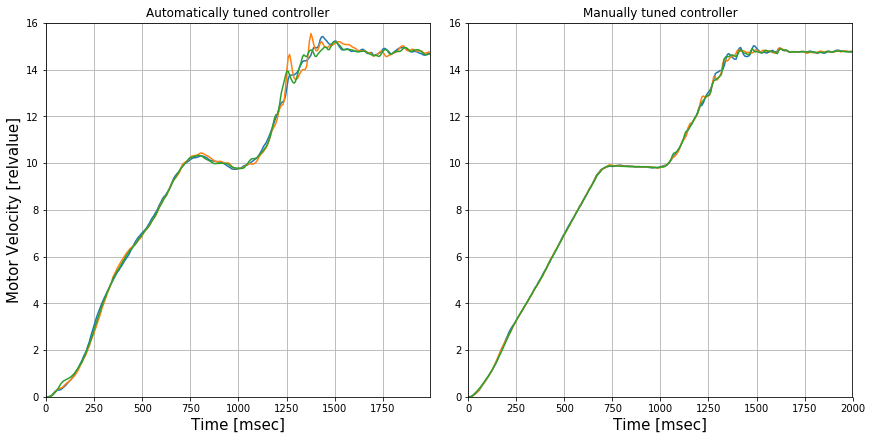

In [3]:
# Plotting the velocity curves
motor_bad = genfromtxt("robotBaseLog_bad.csv", delimiter=";")
motor_good = genfromtxt("robotBaseLog_good.csv", delimiter=";")

fig, (ax0, ax1) = plt.subplots(ncols=2, constrained_layout=True)
ax0.set_xlabel('Time [msec]', size=15)
ax0.set_ylabel('Motor Velocity [relvalue]', size=15)

time0 = motor_bad[:,0] - motor_bad[0,0]
time0 = np.rint(time0 / 1e6)
ax0.plot(time0, motor_bad[:,1:4])
ax0.set_xlim([min(time0), max(time0)])
ax0.set_ylim([0,16])
ax0.grid()
ax0.set_title("Automatically tuned controller")

time1 = motor_good[:,0] - motor_good[0,0]
time1 = np.rint(time1 / 1e6)
ax1.plot(time1, motor_good[:,1:4])
ax1.set_xlim([min(time1), max(time1)])
ax1.set_ylim([0,16])
ax1.grid()
ax1.set_xlabel('Time [msec]', size=15)
ax1.set_title("Manually tuned controller")

fig.set_size_inches(12, 6, forward=True)

plt.show()
#

Above you can see the velocities of each motor before and after tuning the controllers. 

The VMU931 communicates with the computer through the serial port. 
The CRF already contained an interface for it.
I rewrote major part of it, to make it more robust and increase the signal acquisition frequency. 

Finally to make experiments and the plotting of results easier, I wrote a python wrapper for the code with Boost.Python. 
This allows the user to control the robot speed and acceleration from Jupyter Notebook.
The notebook recieves the motor torques and velocities, the gyroscope measurements and the robot position.
This data can quickly be plotted with Matplotlib in the notebook.

## Input shaping

Input shaping is an open-loop control method, which strives to reduce the vibration of flexible mechanisms.    
It is mainly used in cranes and flexible link robotic arms in practice.    
Input shaping can be used to control linear asymptotically stable flexible systems.
The main idea of input shaping lies in the superposition principle.    
The flexible system starts vibrating when an acceleration is introduced to this system, which resuslts in the vibration around zero position.    
When accelerating the structure, instead of using a single impulse, several impulses are applied.    
If the impulses are applied out of phase of the vibration, they simply cancel each other out.    

Let us look at a second order harmonic oscillator. The physical realization of such systems is for example a pendulum.

Bellow the speed of the pendulum can be seen related to time.

\begin{align}
y_{o}(t) & = \left[ \frac{A_{0} \omega}{\sqrt{1 - \xi^2}} e^{-\xi \omega \left( t - t_{0} \right)} \right] sin\left( \omega \sqrt{1 - \xi^2} \left( t - t_{0} \right) \right)
\end{align}

\begin{align}
\omega_{d} & = \omega \sqrt{1 - \xi^2}
\end{align}

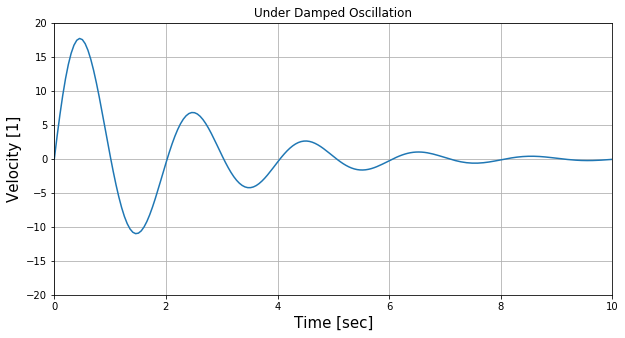

In [4]:
# Second order harmonic oscillator impulse response
def dampedVibration(x, A0, omega, damping, x0):
    if (damping >1):
        return np.inf
    coeff = np.sqrt(1 - damping*damping)
    y = ((A0 * omega) / coeff) * np.exp(-damping * omega * (x - x0)) * np.sin(omega * coeff* (x - x0))
    return y

x = np.linspace(0, 10, 200)
y = dampedVibration(x, 7, 2*np.pi*0.5, 0.15, 0)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(x, y)
ax.set_xlim([0, 10])
ax.set_ylim([-20,20])
ax.grid()
ax.set_xlabel('Time [sec]', size=15)
ax.set_ylabel('Velocity [1]', size=15)
ax.set_title("Under Damped Oscillation")

plt.show()
#

If we have several impulses we can sum the effects together, since the system is linear.

\begin{align}
y_{\sum} \left( t \right) & = \sum_{i=1}^{n}\left[ \frac{A_{0} \omega}{\sqrt{1 - \xi^2}} e^{-\xi \omega \left( t - t_{0} \right)} \right] sin\left( \omega_{d} \left( t - t_{0} \right) \right)
\end{align}



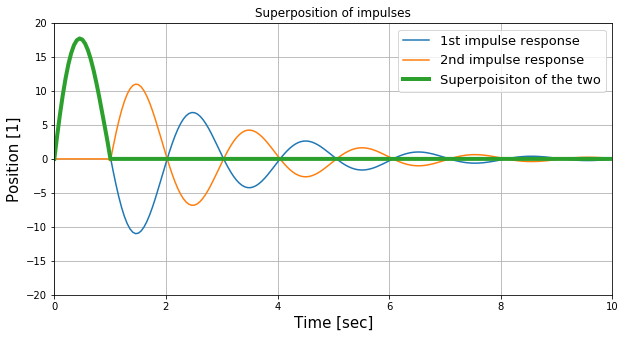

In [5]:
# Superposition of impulses
x = np.linspace(0, 10, 200)
y1 = dampedVibration(x, 7, 2*np.pi*0.5, 0.15, 0)
y2 = -dampedVibration(x, 7, 2*np.pi*0.5, 0.15, 0)
y2[:int(1/10*200)] *= 0
y3 = y1 + y2
fig, ax = plt.subplots(figsize=(10,5))
p1 = ax.plot(x, y1)
p2 = ax.plot(x, y2)
p3 = ax.plot(x, y3, linewidth=4.0)
ax.set_xlim([0, 10])
ax.set_ylim([-20,20])
ax.grid()
ax.set_xlabel('Time [sec]', size=15)
ax.set_ylabel('Position [1]', size=15)
ax.legend((p1[0],p2[0],p3[0]),
          ("1st impulse response","2nd impulse response","Superpoisiton of the two"),
            prop={'size': 13})
ax.set_title("Superposition of impulses")
plt.show()
#

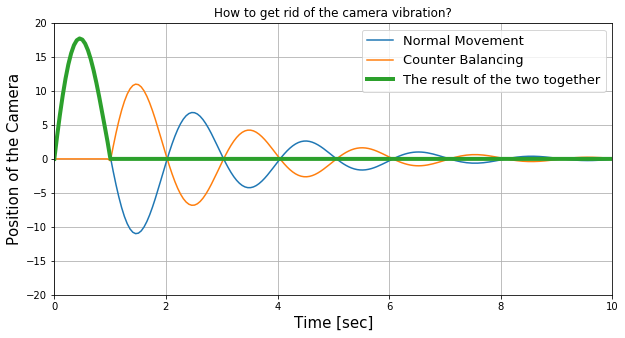

In [6]:
# Superposition of impulses
x = np.linspace(0, 10, 200)
y1 = dampedVibration(x, 7, 2*np.pi*0.5, 0.15, 0)
y2 = -dampedVibration(x, 7, 2*np.pi*0.5, 0.15, 0)
y2[:int(1/10*200)] *= 0
y3 = y1 + y2
fig, ax = plt.subplots(figsize=(10,5))
p1 = ax.plot(x, y1)
p2 = ax.plot(x, y2)
p3 = ax.plot(x, y3, linewidth=4.0)
ax.set_xlim([0, 10])
ax.set_ylim([-20,20])
ax.grid()
ax.set_xlabel('Time [sec]', size=15)
ax.set_ylabel('Position of the Camera', size=15)
ax.legend((p1[0],p2[0],p3[0]),
          ("Normal Movement","Counter Balancing","The result of the two together"),
            prop={'size': 13})
ax.set_title("How to get rid of the camera vibration?")
plt.show()
#

As can be seen on the figure above the method gets rid of the oscillation in the ideal case.    
Unfortunately, there is still a bit of oscillation, since the first half wave is not eliminated.

The method has 3 sets of parameters: number of impulses, the time location of impulses and the proportion of the impulses.    
In the simplest case there is only a pair of impulses, this is called Zero Vibration shaper.

Bellow you can see how to calculate the amplitudes ($A_{i}$) and the time position ($T_i$) of the controller.
$$
\begin{bmatrix}
    A_{i}        \\
    t_{i}       
\end{bmatrix} =
\begin{bmatrix}
    \frac{1}{1 + K}  & \frac{K}{1 + K}     \\
    0  & \frac{\pi}{\omega \sqrt{1 - \xi^{2}}}   
\end{bmatrix}
$$

$$
K = \exp^{\left( \frac{- \xi \pi}{\sqrt{1 - \xi^{2}}} \right)}
$$

For the method to work only the natural frequency and the damping factor of the beam is needed. There is no need for complicated models.

Normally the beam equations are modelled by partial differential equation , either by Bernouilli or Timoshenko. These equations are hard to solve, and their precision highly depends on the precision of the initial conditions.    

I applied an impulse to the flexible beam and recorded the angular velocity of the tip with the gyroscope.
Then fitted the second order harmonic scillator equation to the beam velocity data.    
As can be seen the plot bellow, the model fits the data pretty well.    
Unfortunately, there is a phase shift in the later periods. This might be because the data gets noisy around the peaks, for the first few periods. Since the goodness of the fit is mostly influenced by the first few oscillations.

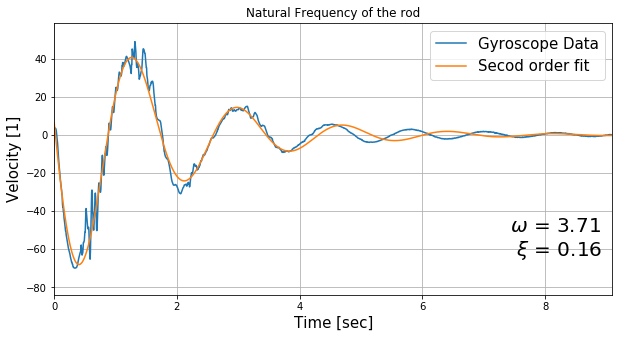

In [7]:
# Plot of rod natural frequency
gyroscope = genfromtxt("vmulog_free.csv", delimiter=";")
y = gyroscope[785:,1]
x = np.linspace(0, y.shape[0] * 0.005, y.shape[0])
fig, ax = plt.subplots(figsize=(10,5))
p1  = ax.plot(x, y)

p0 = [30, 1, 0.1, 0]
popt, pcov = curve_fit(dampedVibration, x, y, p0)
p2 = ax.plot(x, dampedVibration(x, popt[0], popt[1], popt[2], popt[3]))
ax.set_xlim([0, max(x)])
ax.set_ylim([min(y) * 1.2 ,max(y)*1.2])
ax.grid()
ax.set_xlabel('Time [sec]', size=15)
ax.set_ylabel('Velocity [1]', size=15)
ax.legend((p1[0],p2[0]), ("Gyroscope Data","Secod order fit"), prop={'size': 15})
ax.set_title("Natural Frequency of the rod")

ax.text(0.9, 0.2,'$\\omega$ = {:.2f} \n $\\xi$ = {:.2f}'.format( popt[1], popt[2]),
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes, size = 20)
plt.show()
#

In [8]:
# Calculate K and T1
damping = popt[2]
K = np.exp((-damping * np.pi) / (1- damping* damping))
print("The K factor is : {:.2f}".format(K))
print("The first impulse is {:.2f}%, the second impulse is {:.2f}% of the acceleration.".format(1/(1+K)*100, K/(1+K)*100))
omega = popt[1]
# This is in VMU measurement units, which is 5 millisec
t_i = np.pi / (omega * np.sqrt(1-damping* damping))
print("The second impulse is at : {:.3f} msec".format(t_i))
#

The K factor is : 0.59
The first impulse is 62.82%, the second impulse is 37.18% of the acceleration.
The second impulse is at : 0.858 msec


There is one big problem with this method of vibration reduction.
Input shaping gives no guidelines for evaluating how well the shaper works.
It does not take into account the real system. The shaper is ideal only if the actuators and controllers of the robot can produce the required impulses at just the right time.
In real world however there is always some timedelays and overshoots in the controllers.
In my case since I was working with a heavy mobile robot, which has 4 motors I wanted to know if I could do better.

# Cost Functions

One way to get a better input shaper is to try different parameters on the real robot and determine which one is better.
From this feedback we could create an optimization/learning algorithm to find the optimal parameters.

The first step is to create a metric which will show if one run of the parameters were better than the other. I will call this metric loss function.
The loss function has to satisfy the following:
1. the value should not vary between consecutive trials with same parameters
2. the value should change between different sets of parameters

I decided to use the root-mean-square error (RMSE) of the gyroscope values. For the mean I have substitued zero, since the values should be 0 in the longer constant speeds. (The mean of the measurement would be very different from zero, since the oscillation is not symmetric.)

$
RMSE = \sqrt{\frac{\sum{ \left( y_{i} - 0 \right)^{2}}}{N}}
$

Since the robot wheels have no suspensions, the uneven ground will introduce noise to the gyroscope signal.
It is important to get rido of this, otherwise the loss function will be very noisy.

I have recorded a longer run of the robot with constant speed. In constant speed after the inital period the gyroscope should measure values around zero. 

In the figure bellow the measurement values can be seen. As expected the measurements are centered around zero, and they have symmetrical stochastic noise.    

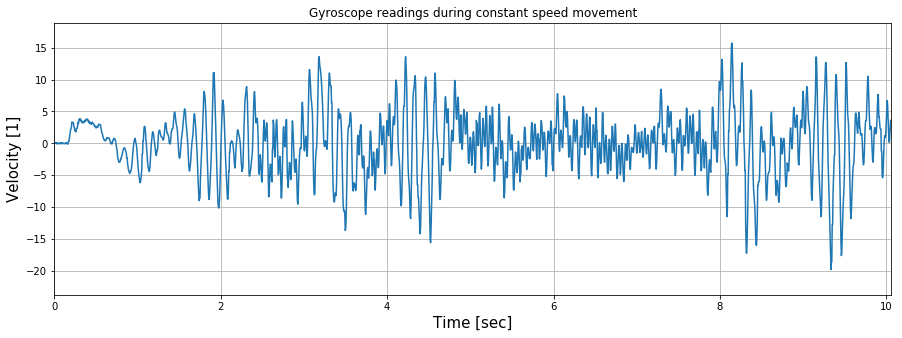

In [9]:
#Steady state
gyroscope = genfromtxt("vmulog_constantv.csv", delimiter=";")
y = gyroscope[:,1]
x = np.linspace(0, y.shape[0] * 0.005, y.shape[0])
fig, ax = plt.subplots(figsize=(15,5))
p1  = ax.plot(x, y)
ax.set_xlim([0, max(x)])
ax.set_ylim([min(y) * 1.2 ,max(y)*1.2])
ax.grid()
ax.set_xlabel('Time [sec]', size=15)
ax.set_ylabel('Velocity [1]', size=15)
ax.set_title("Gyroscope readings during constant speed movement")

plt.show()
#

To better see the noise spectrum I have also plotted the fast fourrier transformation (FFT) of the signal.
There are 3 peaks in the signal. From the previous experiment it can be seen that the beam's natural frequency is around 1 Hz. We can apply a Digital Butterworth filter to get rid of the components higher than 4-5 Hz, to make the loss calculations less noisy.

Bellow the filtered and the original signal can be seen right after the acceleration phase.

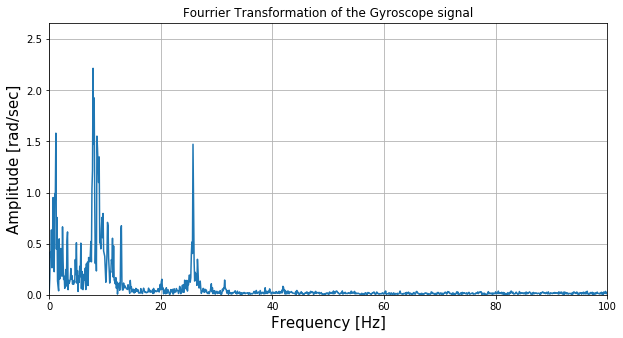

In [10]:
# Fourrier Transform of steady state
import scipy.fftpack
T = 0.005 # sampling time period
N = y.shape[0]
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
ax.set_xlim([0, max(xf)])
ax.set_ylim([min(2.0/N * np.abs(yf[:N//2])) * 1.2 ,max(2.0/N * np.abs(yf[:N//2]))*1.2])
ax.grid()
ax.set_xlabel('Frequency [Hz]', size=15)
ax.set_ylabel('Amplitude [rad/sec]', size=15)
ax.set_title("Fourrier Transformation of the Gyroscope signal")
plt.show()
#

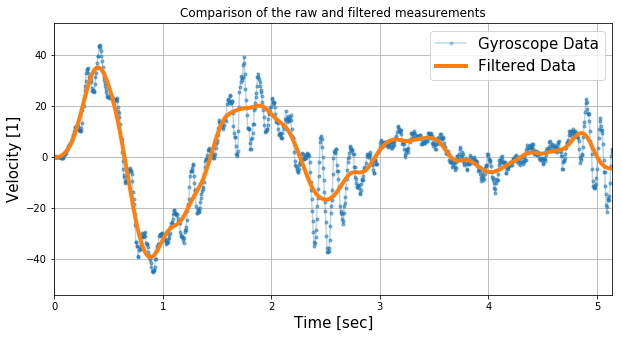

In [11]:
#Filtered Signal
y = genfromtxt("vmulog_accel.csv", delimiter=";")[:,1]
x = np.linspace(0, y.shape[0] * 0.005, y.shape[0])
from scipy import signal
fs = 200 #sampling freq
fc = 4
w = fc / (fs / 2)
b, a = signal.butter(5, w, 'low')
output = signal.filtfilt(b, a, y)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(x, y, marker = ".", alpha = 0.3)
p0 = ax.plot(x, y, marker = ".", alpha = 0.3)
p1 = ax.plot(x, output, linewidth=4)
ax.set_xlim([0, max(x)])
ax.set_ylim([min(y) * 1.2 ,max(y)*1.2])
ax.grid()
ax.set_xlabel('Time [sec]', size=15)
ax.set_ylabel('Velocity [1]', size=15)
ax.set_title("Comparison of the raw and filtered measurements")
ax.legend((p0[0],p1[0]), ("Gyroscope Data","Filtered Data"), prop={'size': 15})

plt.show()
#

# Bayesian Optimization

Now that we have a metric to evaluate which control parameters are better we need to choose an algorithm to propose new parameters.

Machine learning in robotics have several difficulties compared to computer vision:
- there are a limited number of robots, learning can not be parallelized
- each control function evaluation takes long time
- real world robot control and sensors are very noisy

On the other hand when we do not use computer vision, just low dimensional sensor data, the models are much simpler. A gyroscope and the 4 wheels represent 7 dimensions. A small resolution image with 64 x 64 x 3 pixels represents 12288 dimensions.

The available algorithms are also constrained because we have no access to the gradient of the control parameters. 

After careful consideration I have chosen Bayesian optimization for this problem. This can be also considered a reinforcement learning algorithm. 

Bayesian optimization is a global optimization method. Theoretically it finds the best set of parameters.
It does not need the gradients of the loss function. Works with relatively small amount of data.

It is mostly used for finding the optimum in cases where the cost function is very expensive to evaluate. Such as predicting which point is ideal for oil drilling (Krieging), or optimizing machine learning model hyperparameters.

Bayesian optimization works by creating a model of the loss surface based on the previously evaluated points, than proposing a new set of parameters to evaluate.

This loss surface is an $\mathbb{R}^{n} \rightarrow  \mathbb{R}$ function, where n is the number of model parameters. The most common model to use are Gaussian Processes. Other common choice is using decision trees.

Gaussian Processes (GP) are probabilistic curves, where the finite collection of points form a multivariate normal distribution. To put it simpler this is just a different way to fit a curve, can be compared to line fitting with OLS. Instead of fitting a parametric model, such as a line or a sine wave, the function value is determined by key points, and a kernel function which shows how the function value changes between the key points.

Unlike parametric models GPs model the function in a discrete interval. When using Bayesian Optimization we have to set the range where we are looking for the parameter.

GPs are probabilistic models. They do not represent a single function, but a collection of stochastic functions. In practice we look at the mean, most likely, values of the function. From the standard deviaton of these functions we can calculate how certain is a Gaussian process in the function value in a given point. As a rule of thumb the further away we are from the key points, the less certain the model is.


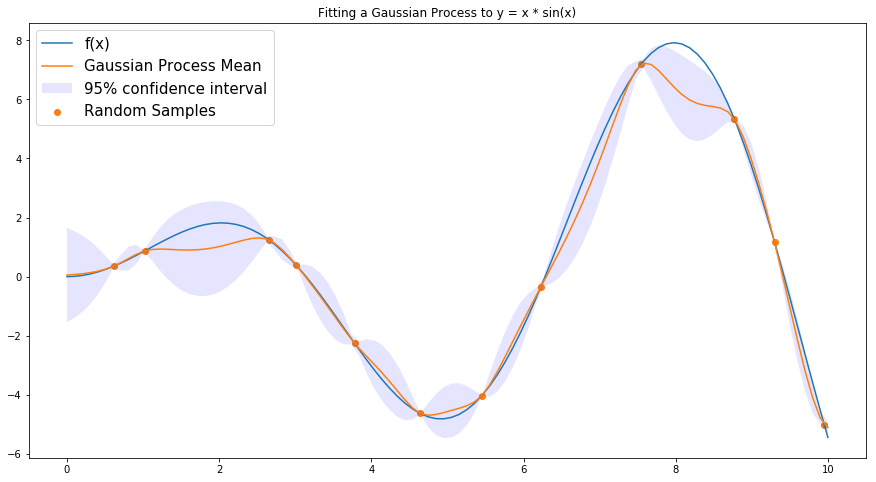

In [12]:
# Fitting a Gaussian Process to the Sine function

def f(x):
    return x * np.sin(x)

x = np.linspace(0,10, 100)
y = f(x)

number_of_samples = 12
gp =GaussianProcessRegressor(
            kernel=Matern(),
            normalize_y=True,
            random_state=5
        )
x_star = np.random.uniform(min(x), max(x), number_of_samples)

y_star = f(x_star)
gp.fit(x_star.reshape(-1, 1), y_star)

m, v = gp.predict(x.reshape(-1, 1), return_std=True)

plt.figure(figsize=(15,8))

p0 = plt.plot(x,y)
fill = plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([m - 1.9600 * v,
                        (m + 1.9600 * v)[::-1]]),
         alpha=.1, fc='b', ec='None', label='95% confidence interval')
sc = plt.scatter(x_star, y_star)
p1 = plt.plot(x,m)

plt.legend((p0[0],p1[0], fill[0], sc),
           ("f(x)","Gaussian Process Mean","95% confidence interval", "Random Samples" ),
           prop={'size': 15})
plt.title("Fitting a Gaussian Process to y = x * sin(x)")
plt.show()
#

Based on the model of the loss at each iteration we need to pick a new set of parameters to probe.
Acquisition function is responsible to suggesting the new location.

There are three common acquisition functions : Expected Improvement (EI), Upper Confidence Bound (UCB) and Probabilty of Improvement (POI).

They suggest new points based on the mean and the standard deviation of the loss. Usually they have a parameter where we can choose the trade off between exploration and explotiation.

If we prefere exploration the acquisition function will prefere points in sample space, where the standard deviation is high. This means that the model is uncertain about the loss values in the given point. By exploring the space better, we ensure that we will find the global imptimum of the problem. On the other hand the optimization will take longer.

If we focus on exploitiation, then the new parameters will be close to points where the mean is minimal. It will make the optimization converge faster to a minumum. However since the algoirthm evaluates smaller part of the parameter space it risks getting stuck in a local optimum.

The trade of between the two have to be set manually. It must be based on how much time we have to evaluate the algorithm.

# Experiments

For the Bayesian Optimization I have tried out several libraries.
I chose to use fmfn/BayesianOptimization because it has very nice logging functionalities.

I run several trials with Matern and RBF kernels of the GaussianProcess.
Tried out the 3 previously mentioned acquisition functions.

The goal of the optimization was to find the optimal shaper parameters. 
To have as much vibration as possible I have fixed the first acceleratioin impulse close to the maximum acceleration of the robot. This way only the time location of the second impulse ($t_{2}$), and the amplitude ($A_{2}$) of the second impulse had to be found. 

The robot was running in the lab. There are 2 bumpers in the runway, which add noise to the trials.
To make each execution as similar as possible, I did one run forward and one backward. Calculated the mean of the two runs. Each trial took around 15 seconds. An experiment consisted of 5 initial random values, and 30 optimization steps.

Bellow you can see a video of one optimization process. The posterior mean, corresponds to the predicted value of the loss function. The higher the value, the better the parameters are. The posterior standard deviation shows the uncertainty of the predicted mean. It can be observed that at points which were evaluated the standard deviation is close to zero. At points far from evaluations the standard deviation is higher.

In [13]:
# Optimization video
gp =GaussianProcessRegressor(
            kernel=Matern(length_scale=[5, 10]),#RBF(length_scale=[0.05, 1]),
            alpha=1e-6,
            normalize_y=True,
            n_restarts_optimizer=5,
            random_state=5
        )
#Load data
log = "logs_kappa5.json"
x = []
y = []
with open(log, "r") as f:
    for line in f:
        line = json.loads(line)
        y.append(line["target"])
        x.append([line["params"]["a1"],line["params"]["t1"]])
x = np.array(x)

label_x = "A1"
label_y = "T1"
bounds = [[0, 1.5],[300,1000]]

X1 = np.linspace(0, 1.5, 200)
X2 = np.linspace(300, 1000, 200)
x1, x2 = np.meshgrid(X1, X2)
X = np.hstack((x1.reshape(200*200,1),x2.reshape(200*200,1)))

fig = plt.figure(figsize=(13,5))


def update(i):
    fig.clear()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    gp.fit(x[:i],y[:i])
    m, v = gp.predict(X, return_std=True)

    cf1 = ax1.contourf(X1, X2, m.reshape(200,200),100)
    ax1.plot(x[:i-1,0], x[:i-1,1], 'r.', markersize=10, label=u'Observations')
    ax1.plot(x[i,0], x[i,1], 'r.', markersize=25, label=u'New Point')
    cb1 = fig.colorbar(cf1, ax=ax1)
    ax1.set_xlabel(label_x)
    ax1.set_ylabel(label_y)
    
    ax1.set_title('Posterior mean')
    ##
    ax2.plot(x[i,0], x[i,1], 'r.', markersize=25, label=u'New Point')
    ax2.plot(x[:i-1,0], x[:i-1,1], 'r.', markersize=10, label=u'Observations')
    cf2 = ax2.contourf(X1, X2, np.sqrt(v.reshape(200,200)),100)
    cb2 = fig.colorbar(cf2, ax=ax2)
    ax2.set_xlabel(label_x)
    ax2.set_ylabel(label_y)
    
    ax2.set_title('Posterior sd.')
    return ax1, ax2
#

<Figure size 936x360 with 0 Axes>

In [14]:
anim = FuncAnimation(fig, update, frames=np.arange(3, x.shape[0]), interval=500)
anim.save('line.gif', dpi=80, writer='imagemagick')
HTML(anim.to_html5_video())

On the figure bellow you can see the comparison of the different shapers. No shaping case is where the robot is left to acclerate from standing position to the desired velocity directly. 

The analytic shaper was created simply using the beam natural frequency and damping. It is clearly superior to the no shaper case.

Finally, the Bayesian Shaper is the result of the optimization method. It has out performed the analytical shaper in all 10 trials.

(10,)


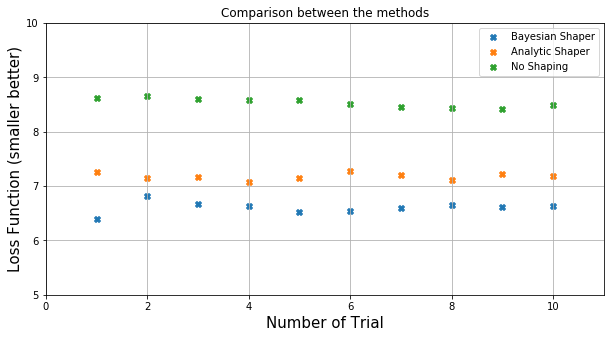

In [15]:
#Comparison of methods
y = genfromtxt("b_s_n.csv", delimiter=";")
x = np.linspace(1, y.shape[0], y.shape[0])
print(x.shape)
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(x, y[:,0], marker = "X")
ax.scatter(x, y[:,1], marker = "X")
ax.scatter(x, y[:,2], marker = "X")
ax.set_xlim([0, max(x)+1])
ax.set_ylim([5 ,10])
ax.grid()
ax.set_xlabel('Number of Trial', size=15)
ax.set_ylabel('Loss Function (smaller better)', size=15)
plt.legend(("Bayesian Shaper","Analytic Shaper", "No Shaping"))
ax.set_title("Comparison between the methods")
plt.show()
#

On the video bellow the camera feed can be seen from the top of the beam. 
There is considerably less vibration in the video then during the original control of the robot.

In [16]:
HTML('<iframe width="300" height="500" src="https://www.youtube.com/embed/lYZm8Lcw7tc" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

/home/robotronics/.local/lib/python3.5/site-packages/IPython/core/display.py:694: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Discussion

In my experience Bayesian Optimization is a very reliable algorithm. It can find the global optima at each trial, and does overperform the analytic case very stably.

The biggest failure points of the method is setting the the initial parameters of the Gaussian Process and finding a good exploration-exploitation trade off. 

The frameworks I have looked at all initialize the Gaussian Process with a single dimensional length scale parameter. If the parameters however are not in the same order of magnitude, the optimization method will disregard one of the dimensions. 

The exploration parameter can be set, by trying a few values. If the optimization quickly converges to local minima, after 5-10 trials, we should increase the exploration term.

In the future this method could be extanded to work with different flexible beam heights. The length of the beam could be considered a parameter, which the algorithm can not change. This type of optimization is called contextual Bayesian Optimization.

Finally, instead of using a 2 impulse shaper Bayesian Optimization could be used to predicta whole velocity trajectory. This would increase the dimensionality of the problem, but I believe it could work very well.